In [139]:
from os import listdir
from os.path import isfile, join
import re
demographic_files = [f for f in listdir('BabyNames/') if isfile(join('BabyNames/', f)) and re.search('^yob\d', f)]
demographic_files.sort()

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [140]:
import pandas as pd
def read_file(file_name):
    year = re.search('yob(\d+).txt', file_name).group(1)
    df = pd.read_csv('BabyNames/{0}'.format(file_name), sep=',', header=None)
    df.columns = ['Name', 'Sex', 'Count']
    df['Year'] = year
    return df

read_data_frames = [read_file(f_name) for f_name in demographic_files]

# Выполнение пункта 1 задания "Сгруппируйте данные по полу и году и визуализируйте общую динамику рождаемости обоих полов"

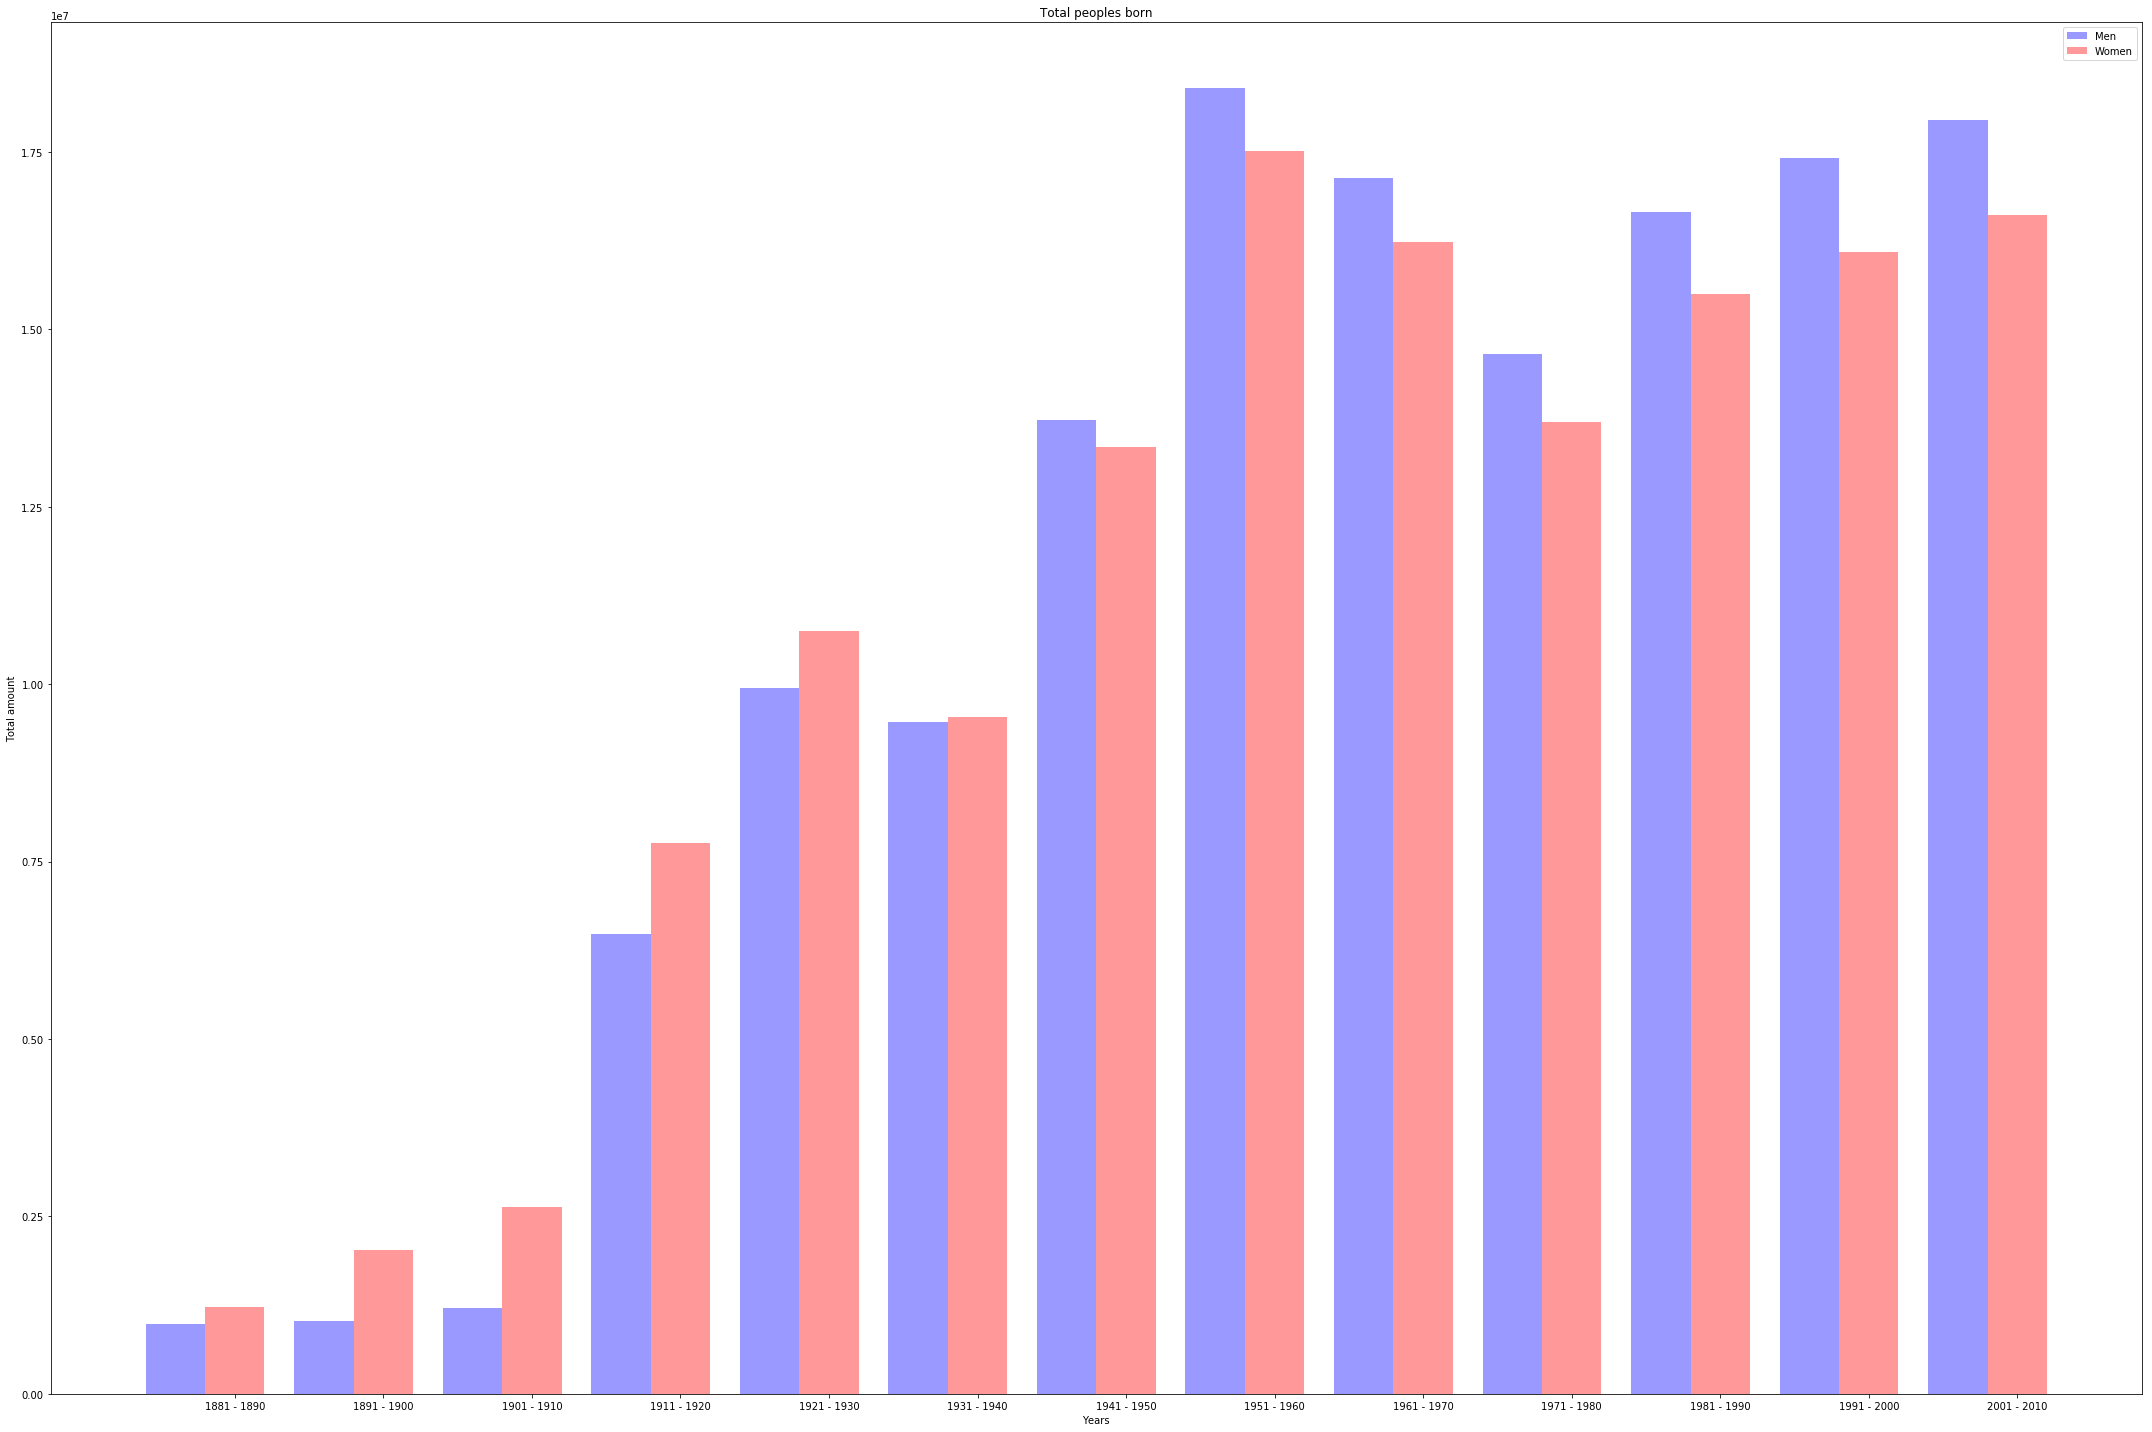

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

start_index = 1
end_index = 130
interval = 10

n_groups = len(read_data_frames[start_index:end_index]) / interval

years = []
mens_amount = []
womens_amount = []

def year_interval_name(frames, start_index, end_index):
    start_year = frames[start_index].loc[0]['Year']
    end_year = frames[end_index].loc[0]['Year']
    return '{0} - {1}'.format(start_year, end_year)

for index in range(start_index, end_index, interval):
    start_frame_index = index
    end_frame_index = index + interval - 1
    interval_mens_amount = 0
    interval_womens_amount = 0
    for frame in read_data_frames[start_frame_index:end_frame_index]:
        interval_mens_amount += frame.loc[frame['Sex'] == 'M', ['Count']].sum()['Count']
        interval_womens_amount += frame.loc[frame['Sex'] == 'F', ['Count']].sum()['Count']

    years += [year_interval_name(read_data_frames, start_frame_index, end_frame_index)]
    mens_amount += [interval_mens_amount]
    womens_amount += [interval_womens_amount]

years_values = tuple(years)
womens_values = tuple(womens_amount)
mens_values = tuple(mens_amount)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.4

opacity = 0.4

rects1 = ax.bar(index, mens_values, bar_width,
                alpha=opacity, color='b',
                label='Men')

rects2 = ax.bar(index + bar_width, womens_values, bar_width,
                alpha=opacity, color='r',
                label='Women')

ax.set_xlabel('Years')
ax.set_ylabel('Total amount')
ax.set_title('Total peoples born')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(years_values)
ax.legend()

fig.tight_layout()
plt.rcParams["figure.figsize"] = [30, 20]
plt.show()



# Выполнение пункта 2 задания "Найдите самые популярные имена за всю историю"

Количество людей по годам сильно меняется. Следовательно нельзя просто сложить количества людей и получить ответ.
Кроме этого очевидно что надо брать те, что на вершине списка т.к. в дата фрейме данные уже отсортированы по частоте.
Предположительно необхоимо найти N (у нас N будет 500) наиболее часто встречающихся, в процентном соотношении для совего года. Посчитать статистику по всем годам. И вот тут уже сложить все проценты и отсортировать по суммарному значению.

In [142]:
def count_percentage_for_set(data_frame, gender, limit=500):
    filtered_by_gender = data_frame.loc[data_frame['Sex'] == gender]
    probe = filtered_by_gender[0:limit]
    total_count = filtered_by_gender.get(['Count']).sum()['Count']
    probe['Relative frequency'] = probe['Count'].map(lambda count: count / total_count)
    result = probe.get(['Name', 'Relative frequency'])
    return result

def get_most_frequent(percentages_list, limit=150):
    total_data_frame = pd.concat(percentages_list).groupby(['Name']).sum()
    result = total_data_frame.sort_values(by='Relative frequency', ascending=False)[0:limit]
    return result

male_percentages = []
for frame in read_data_frames:
    male_percentages += [count_percentage_for_set(frame, 'M')]

female_percentages = []
for frame in read_data_frames:
    female_percentages += [count_percentage_for_set(frame, 'F')]

chart_size = 10
males_chart = get_most_frequent(male_percentages, chart_size)
females_chart = get_most_frequent(female_percentages, chart_size)



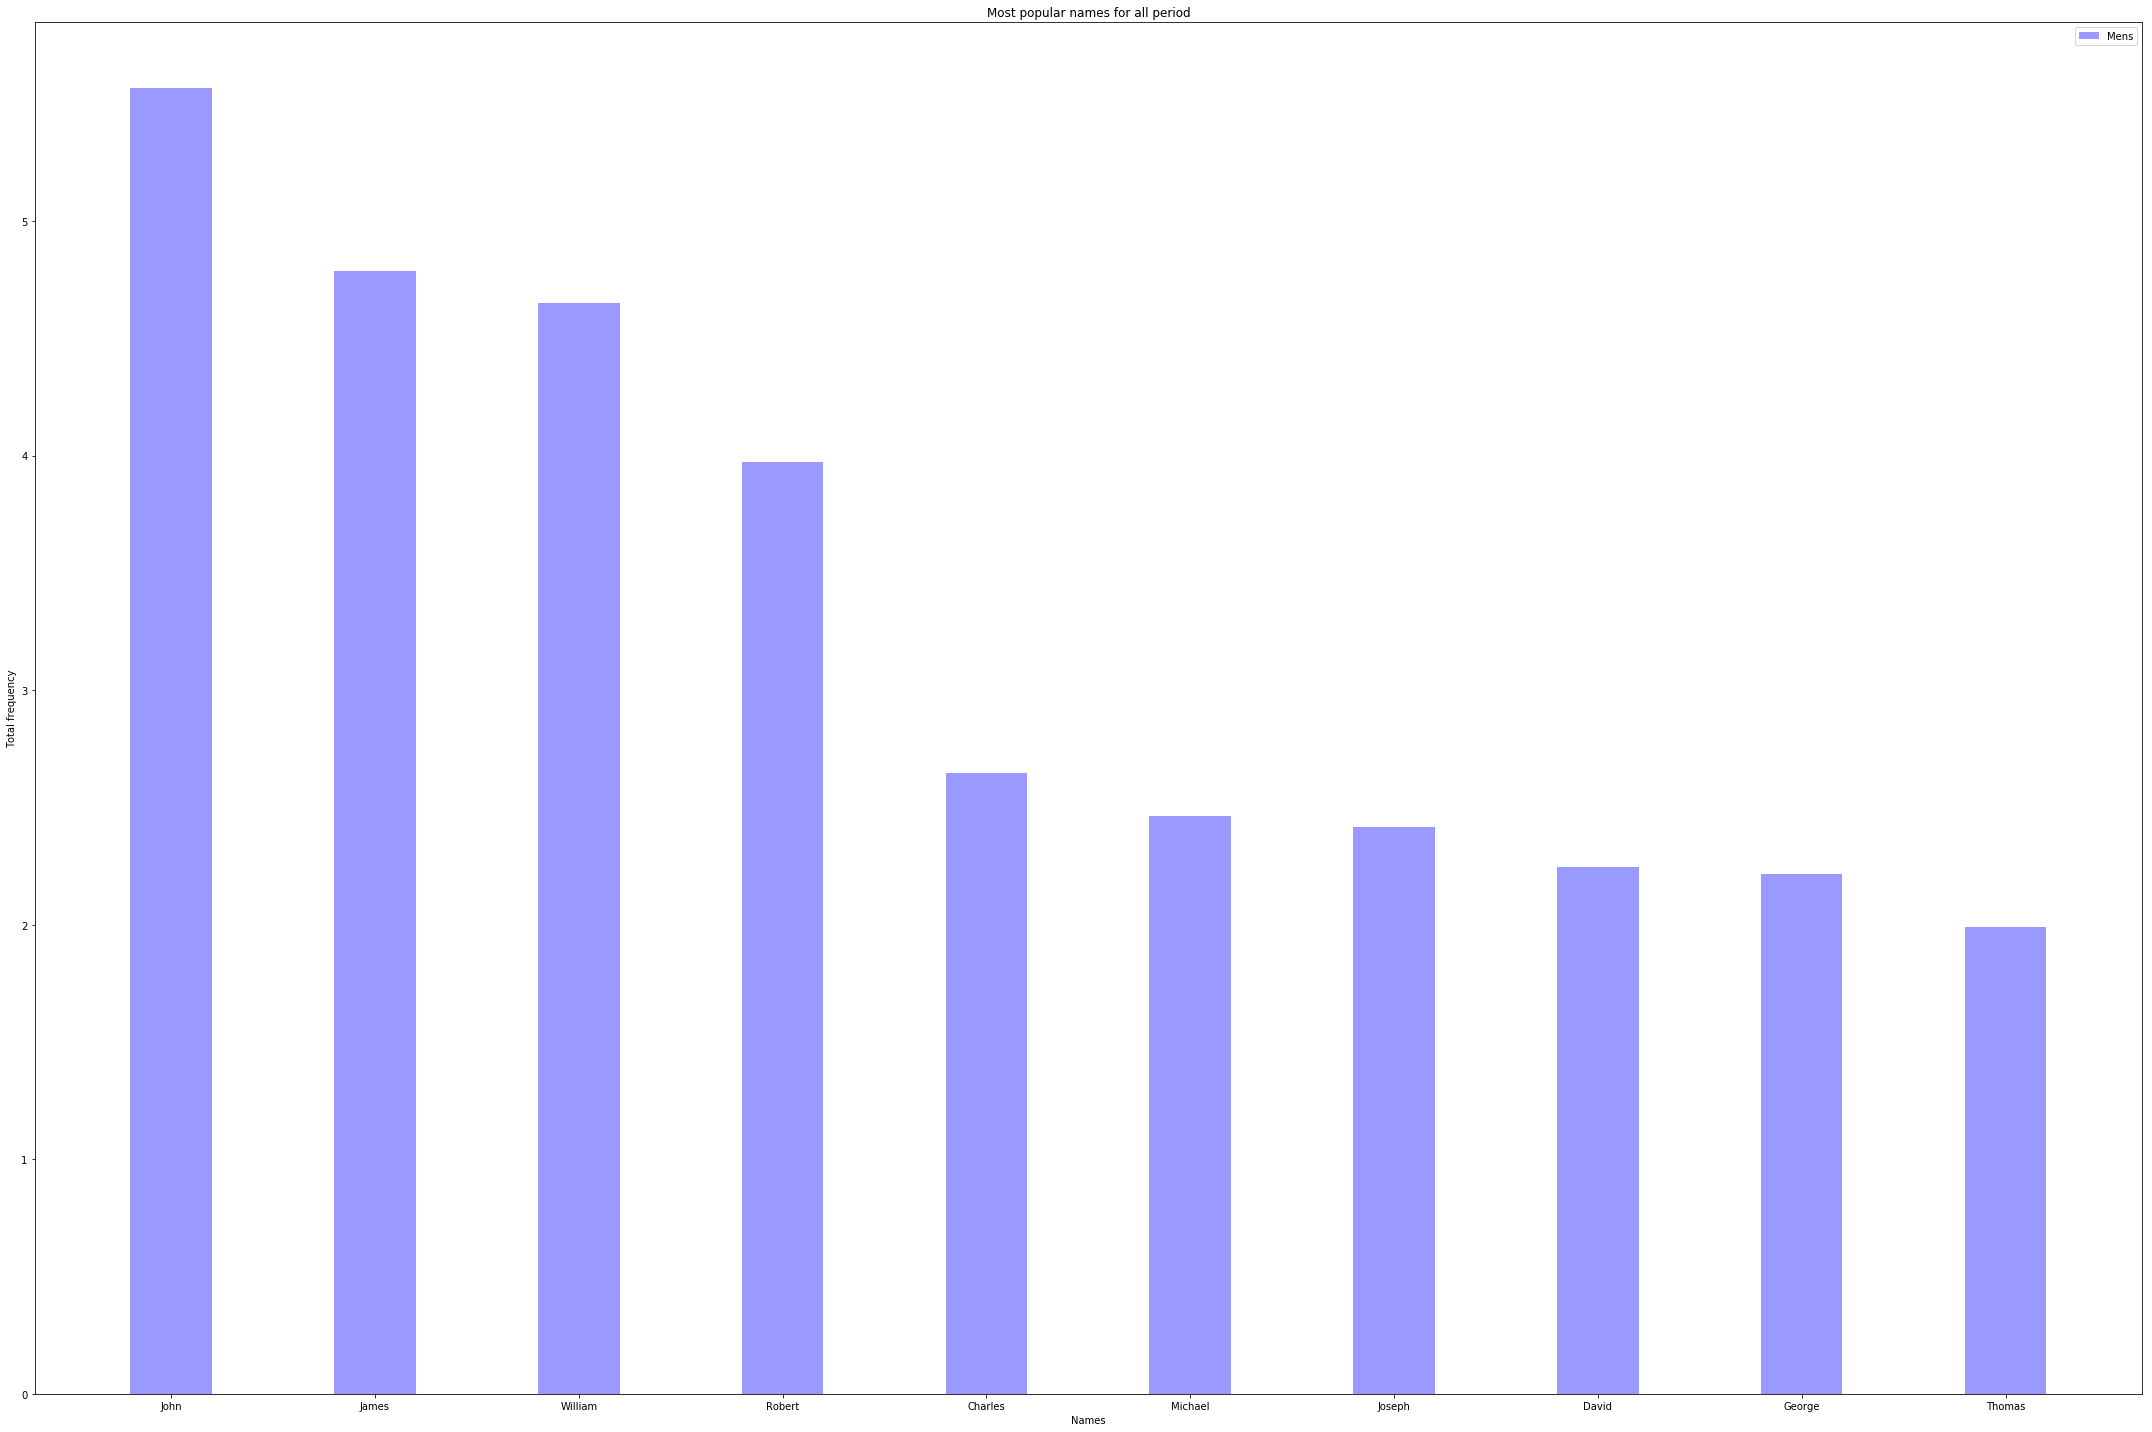

In [143]:

male_fig, male_ax = plt.subplots()

index = np.arange(chart_size)
bar_width = 0.4

opacity = 0.4

male_values = tuple([values[0] for values in males_chart[0:chart_size].get(['Relative frequency']).get_values().tolist()])
male_names = tuple(males_chart[0:chart_size].index.get_values())

most_popular_male_names = male_ax.bar(index, male_values, bar_width,
                                      alpha=opacity, color='b',
                                      label='Mens')

male_ax.set_xlabel('Names')
male_ax.set_ylabel('Total frequency')
male_ax.set_title('Most popular names for all period')
male_ax.set_xticks(index)
male_ax.set_xticklabels(male_names)
male_ax.legend()

male_fig.tight_layout()
plt.rcParams["figure.figsize"] = [6, 4.8]
plt.show()

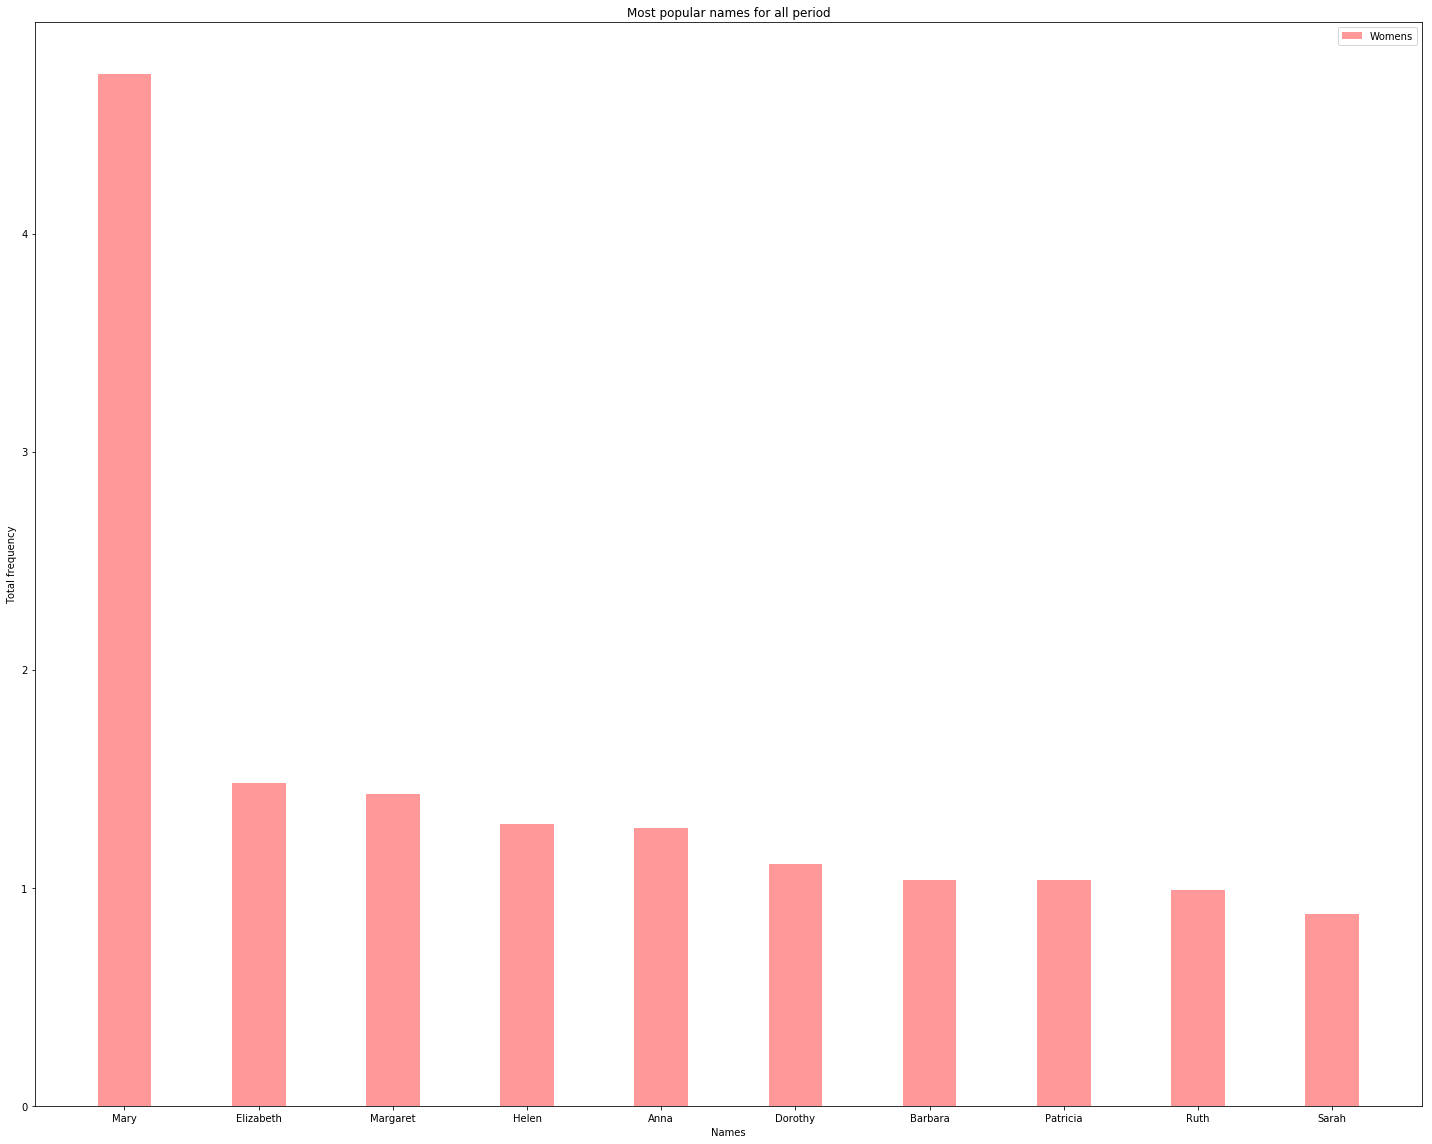

In [159]:
female_fig, female_ax = plt.subplots()

index = np.arange(chart_size)
bar_width = 0.4

opacity = 0.4

female_values = tuple([values[0] for values in females_chart[0:chart_size].get(['Relative frequency']).get_values().tolist()])
female_names = tuple(females_chart[0:chart_size].index.get_values())

most_popular_female_names = female_ax.bar(index, female_values, bar_width,
                                      alpha=opacity, color='r',
                                      label='Womens')

female_ax.set_xlabel('Names')
female_ax.set_ylabel('Total frequency')
female_ax.set_title('Most popular names for all period')
female_ax.set_xticks(index)
female_ax.set_xticklabels(female_names)
female_ax.legend()

female_fig.tight_layout()
plt.rcParams["figure.figsize"] = [30, 20]
plt.show()

# Выполнение пункта 3 задания "Разбить все наблюдения на 10 отрезков, посчитать самое популярное для каждого отрезка имя и построить динамику популярности"

Алгоритм поиска популярности можно взять из 3 пункта. Для отображения популярности каждого из имён необходимо использовать новый тип диаграмм.

In [145]:
start_index = 1
end_index = 130
interval = 13

n_groups = len(read_data_frames[start_index:end_index]) / interval

years = []
mens_amount = []
womens_amount = []

def year_interval_name(frames, start_index, end_index):
    start_year = frames[start_index].loc[0]['Year']
    end_year = frames[end_index].loc[0]['Year']
    return '{0} - {1}'.format(start_year, end_year)

def count_percentage_for_set(data_frame, gender, limit=500):
    filtered_by_gender = data_frame.loc[data_frame['Sex'] == gender]
    probe = filtered_by_gender[0:limit]
    total_count = filtered_by_gender.get(['Count']).sum()['Count']
    probe['Relative frequency'] = probe['Count'].map(lambda count: count / total_count)
    result = probe.get(['Name', 'Relative frequency'])
    return result

def get_most_frequent(percentages_list, limit=150):
    total_data_frame = pd.concat(percentages_list).groupby(['Name']).sum()
    result = total_data_frame.sort_values(by='Relative frequency', ascending=False)[0:limit]
    return result

def calculate_most_frequent_for_ranges(frames, gender, interval):
    start_index = 0
    end_index = len(frames) - 1
    result = []
    for index in range(start_index, end_index, interval):
        interval_percentages = []
        for frame in frames[index:index + interval - 1]:
            interval_percentages += [count_percentage_for_set(frame, gender, limit=100)]
        result += [get_most_frequent(interval_percentages, 1).index.get_values()[0]]
    return result

def calculate_years_intervals(frames, interval):
    start_index = 0
    end_index = len(frames) - 1
    return [year_interval_name(frames, index, index + interval - 1) for index in range(start_index, end_index, interval)]

years = calculate_years_intervals(read_data_frames, interval)


mans_names_for_intervals = calculate_most_frequent_for_ranges(read_data_frames[start_index:end_index], 'M', 13)
womans_names_for_intervals = calculate_most_frequent_for_ranges(read_data_frames[start_index:end_index], 'F', 13)

In [146]:
most_frequent_names = pd.DataFrame({
    'Mans name': mans_names_for_intervals,
    'Womans name': womans_names_for_intervals
}, index=years)
print(most_frequent_names)

            Mans name Womans name
1880 - 1892      John        Mary
1893 - 1905      John        Mary
1906 - 1918      John        Mary
1919 - 1931    Robert        Mary
1932 - 1944    Robert        Mary
1945 - 1957     James       Linda
1958 - 1970   Michael        Lisa
1971 - 1983   Michael    Jennifer
1984 - 1996   Michael     Jessica
1997 - 2009     Jacob       Emily


In [160]:
uniq_mans_names = list(set(mans_names_for_intervals))
uniq_womans_names = list(set(womans_names_for_intervals))

def calculate_popularity(frame, name):
    name_in_chart = frame.loc[frame['Name'] == name]
    if(len(name_in_chart) > 0):
        index = name_in_chart.index.get_values()[0]
        max_index = len(frame) - 1
        return (max_index - index) / max_index
    return 0

def average_popularity_by_intervals(name, frames, interval):
    start_index = 0
    end_index = len(frames) - 1
    result = []
    for index in range(start_index, end_index, interval):
        interval_popularities = [calculate_popularity(frame, name) for frame in frames[index:index + interval - 1]]
        result += [np.mean(interval_popularities)]
    return result

def calculate_popularity_for_list(names_list, frames, gender, interval):
    result = dict()

    filtered_by_gender = [frame.loc[frame['Sex'] == gender].reset_index() for frame in frames]

    for name in names_list:
        result[name] = average_popularity_by_intervals(name, filtered_by_gender, interval)

    return result

def print_popularity(popularity_dict, years, title):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    color_index = 0
    man_fig, man_ax = plt.subplots()
    for name, popularity in popularity_dict.items():
        man_ax.plot(years, popularity, color=colors[color_index], label=name)
        color_index += 1
    man_ax.set_title(title)
    man_ax.legend()
    plt.rcParams["figure.figsize"] = [20, 16]
    plt.show()
    return

mans_data = calculate_popularity_for_list(uniq_mans_names, read_data_frames, 'M', interval)
womans_data = calculate_popularity_for_list(uniq_womans_names, read_data_frames, 'F', interval)

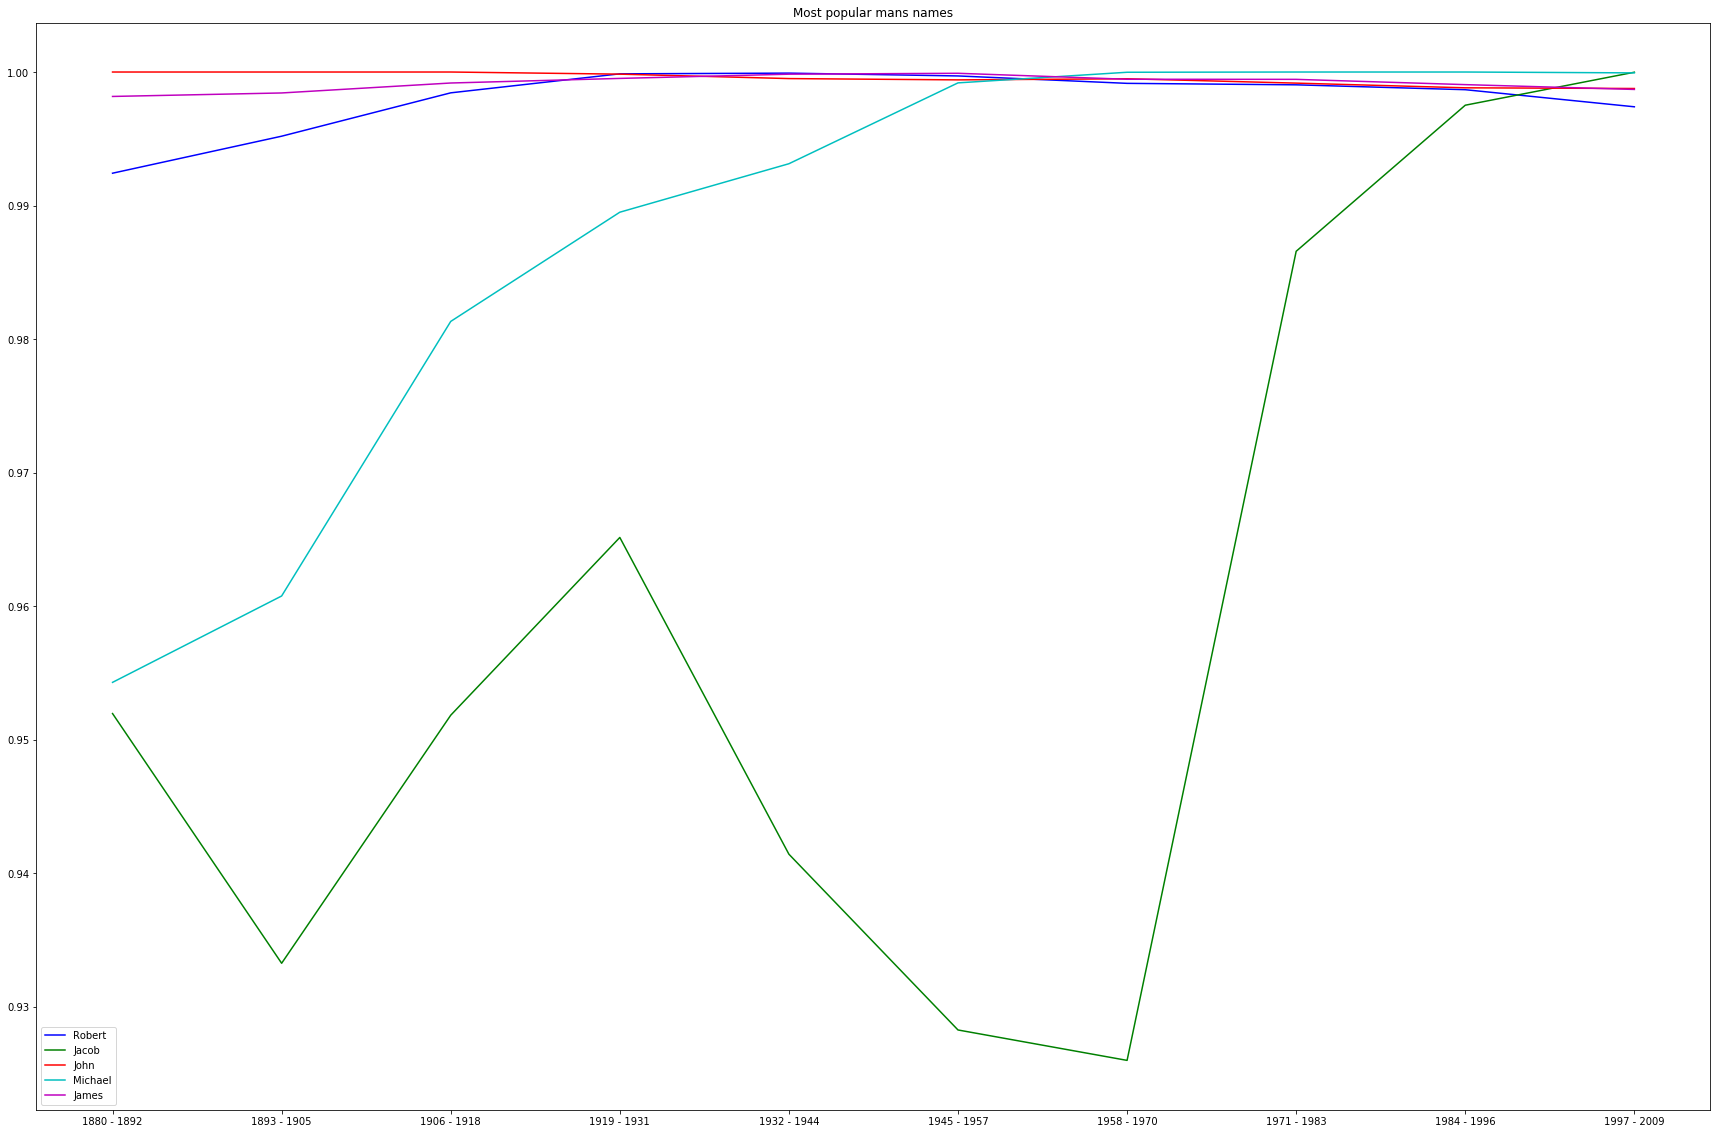

In [161]:
print_popularity(mans_data, years, 'Most popular mans names')

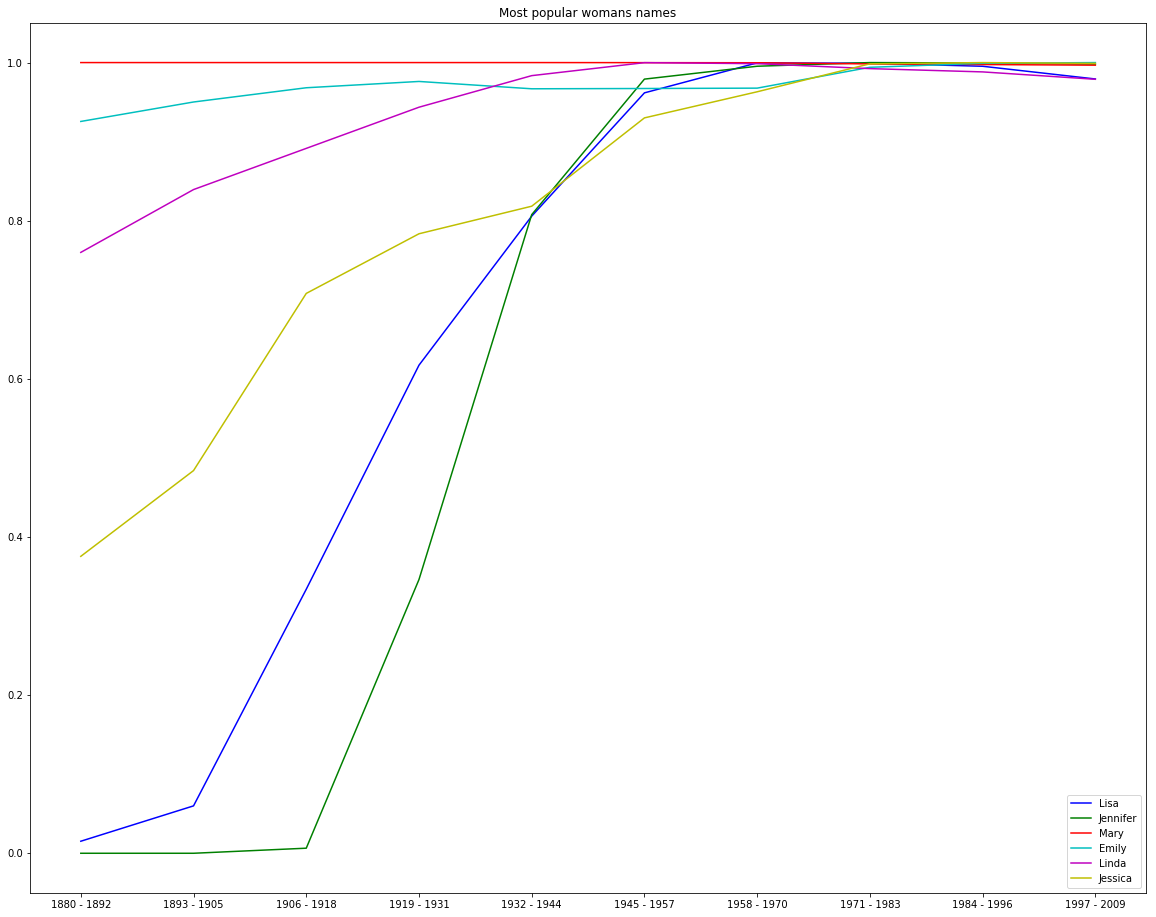

In [162]:
print_popularity(womans_data, years, 'Most popular womans names')

# Выполнение пункта 4 задания "Для каждого года рассчитайте сколько имен покрывают 50% людей, визуализируйте"

Для отображения используем PIE диаграмму. Очевидно что все графики реализовывать не надо - необходимо написать функцию. Которая позволяет отобразить статистику за любой год 

In [163]:
import matplotlib.pyplot as plt

def count_percentage_for_set(frame):
    total_count = clculate_total_count(frame)
    frame['Relative frequency'] = frame['Count'].map(lambda count: count / total_count)
    return frame.loc[:,['Name', 'Relative frequency']]

def filter_by_gender(frame, gender):
    return frame.loc[frame['Sex'] == gender].reset_index()

def clculate_total_count(frame):
    return frame.loc[:,['Count']].sum()['Count']

def take_half_population_names(frame):
    threshold = clculate_total_count(frame) / 2
    sum = 0
    threshold_index = 0
    for index, row in frame.iterrows():
        sum += row['Count']
        if sum > threshold:
            threshold_index = index
            break
    return frame[0:threshold_index]

def calculate_half_population_names(frame, gender):
    filtered_by_gender = filter_by_gender(frame, gender)
    half_population_frame = take_half_population_names(filtered_by_gender)
    half_populaton_names = count_percentage_for_set(half_population_frame)
    year = half_population_frame.loc[0]['Year']
    return (half_populaton_names, year)

def print_statistics(frame, gender):
    (names, year) = calculate_half_population_names(frame, gender)

    fig, ax = plt.subplots(figsize=(20, 20), subplot_kw=dict(aspect="equal"))

    data = names.get('Relative frequency').tolist()
    names = names.get('Name').tolist()


    def pie_label(pct):
        return "{:.1f}%".format(pct)

    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: pie_label(pct), textprops=dict(color="w"))

    ax.legend(wedges, names,
              title="Names",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=8, weight="bold")

    gender_name= '' 
    if gender == 'M':
        gender_name = 'Male'
    else:
        gender_name = 'Female'

    ax.set_title("{0} {1} names 50% distribution".format(year, gender_name))

    plt.show()
    return

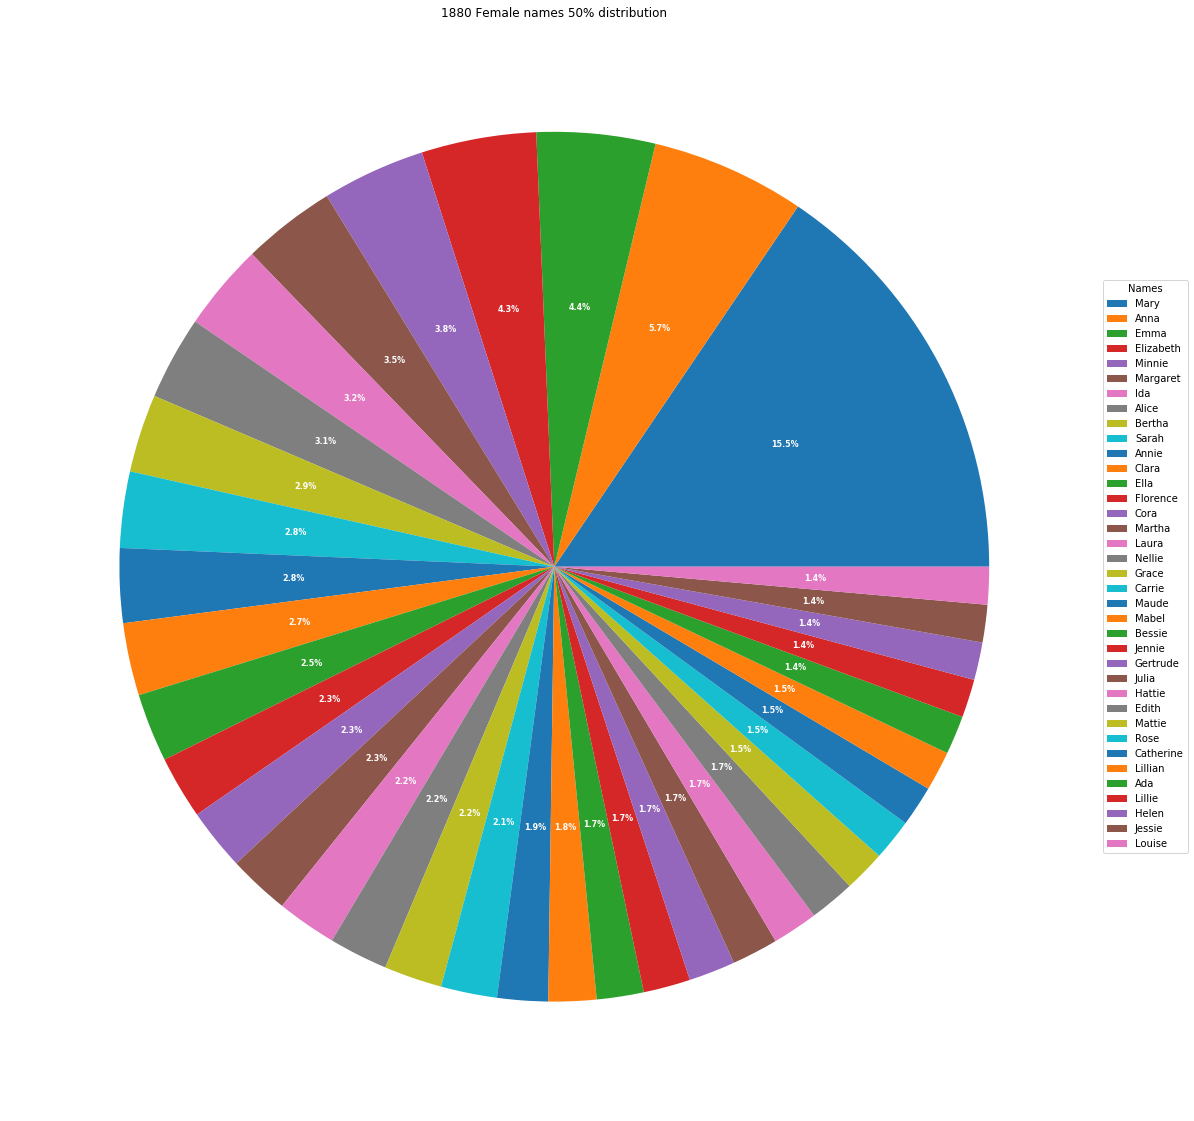

In [164]:
print_statistics(read_data_frames[0], 'F')

# Выполнение пункта 5 задания "Выберите 4 года из всего промежутка и отобразите для каждого года распределение по первой букве в имени, по последней букве в имени"

Для отображения будем испоьзовать колоночную диаграмму как в первом задании т.к. данные очевидно неравномерно распределены. Гистограмма не подходит.

In [165]:
import matplotlib.pyplot as plt

first_char_column = 'FirstChar'
last_char_column = 'LastChar'
relative_frequency_column = 'Relative Frequency'
all_chars = [chr(c) for c in range(ord('a'), ord('z')+1)]


def calculate_total_count(frame):
    return frame.loc[:, ['Count']].sum()['Count']


def normalize_data_frame(frame, char_column):
    frame_dict = {}
    for char, row in frame.iterrows():
        frame_dict[char] = row[relative_frequency_column]

    normalized_df = pd.DataFrame({char_column: all_chars})
    normalized_df[relative_frequency_column] = normalized_df[char_column].apply(lambda ch: frame_dict.get(ch, 0))
    return normalized_df

def count_field_percentage_for_set(frame, field):
    total_count = calculate_total_count(frame)
    frame[relative_frequency_column] = frame['Count'].map(lambda count: count / total_count)
    grouped_fields = frame.loc[:, [field, relative_frequency_column]].groupby(field).sum()
    grouped_result = grouped_fields.sort_values(by=field)
    normalized_result = normalize_data_frame(grouped_result, field)
    return normalized_result


def char_range(c1, c2):
    return [chr(c) for c in range(ord(c1), ord(c2)+1)]


def add_first_and_last_char(frame):
    frame[first_char_column] = frame['Name'].map(lambda name: name[0].lower())
    frame[last_char_column] = frame['Name'].map(lambda name: name[-1].lower())
    return frame


def calculate_first_and_last_chars_statistics(frame):
    frame = add_first_and_last_char(frame)
    first_char_frame = count_field_percentage_for_set(frame, first_char_column)
    last_char_frame = count_field_percentage_for_set(frame, last_char_column)

    fig, ax = plt.subplots()

    bar_width = 0.4

    index = np.arange(len(first_char_frame))

    opacity = 0.4

    rects1 = ax.bar(index, first_char_frame.get(relative_frequency_column).tolist(), bar_width,
                    alpha=opacity, color='b',
                    label=first_char_column)

    rects2 = ax.bar(index + bar_width, last_char_frame.get(relative_frequency_column).tolist(), bar_width,
                    alpha=opacity, color='r',
                    label=last_char_column)
    year = frame.loc[0]['Year']
    ax.set_xlabel('Chars')
    ax.set_ylabel(relative_frequency_column)
    ax.set_title('Frequencies of chars {0} Year'.format(year))
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(first_char_frame.get(first_char_column).tolist())
    ax.legend()

    fig.tight_layout()
    plt.rcParams["figure.figsize"] = [20, 16]
    plt.show()

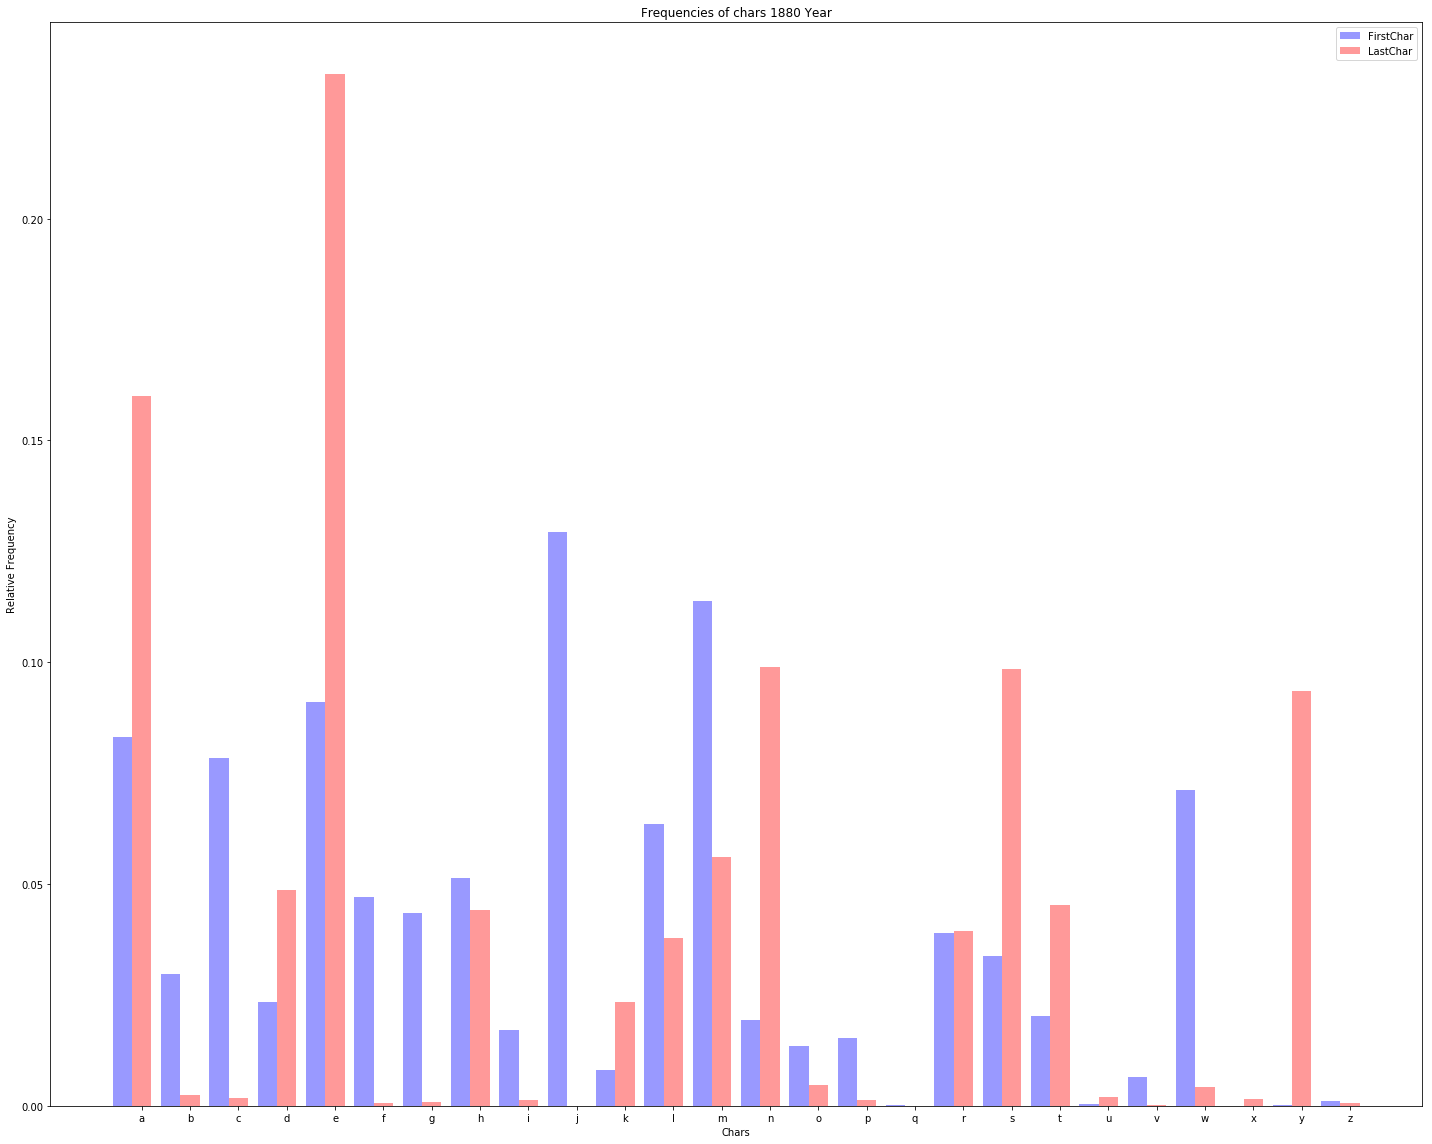

In [166]:
calculate_first_and_last_chars_statistics(read_data_frames[0])

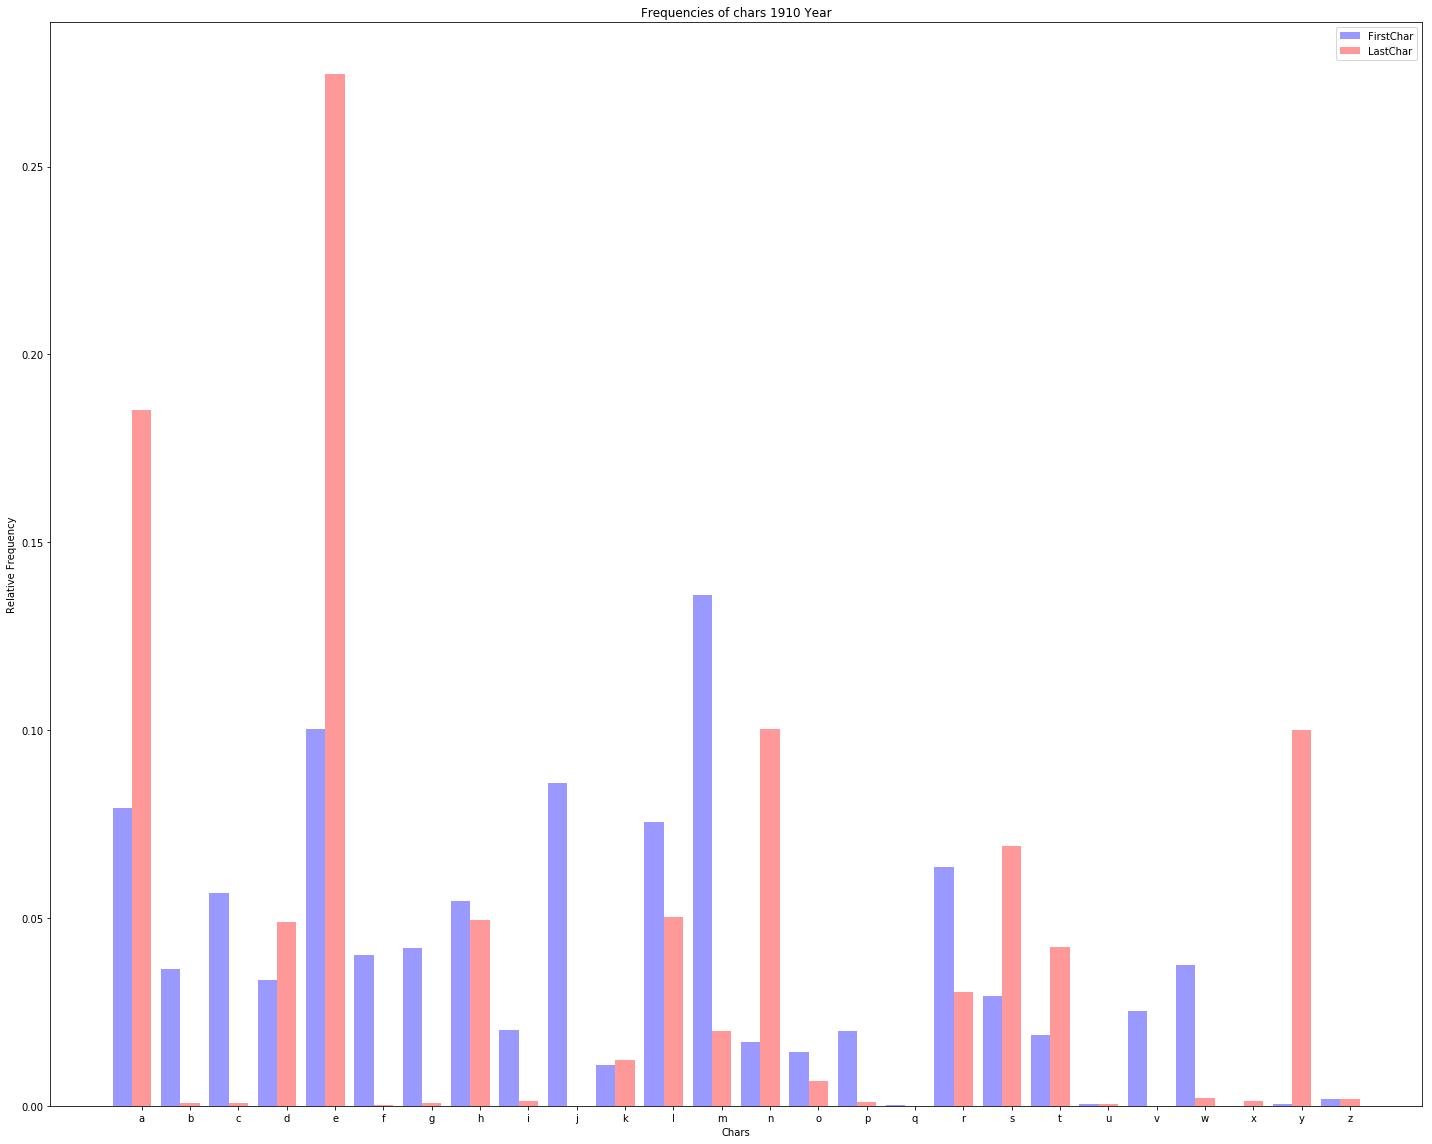

In [167]:
calculate_first_and_last_chars_statistics(read_data_frames[30])

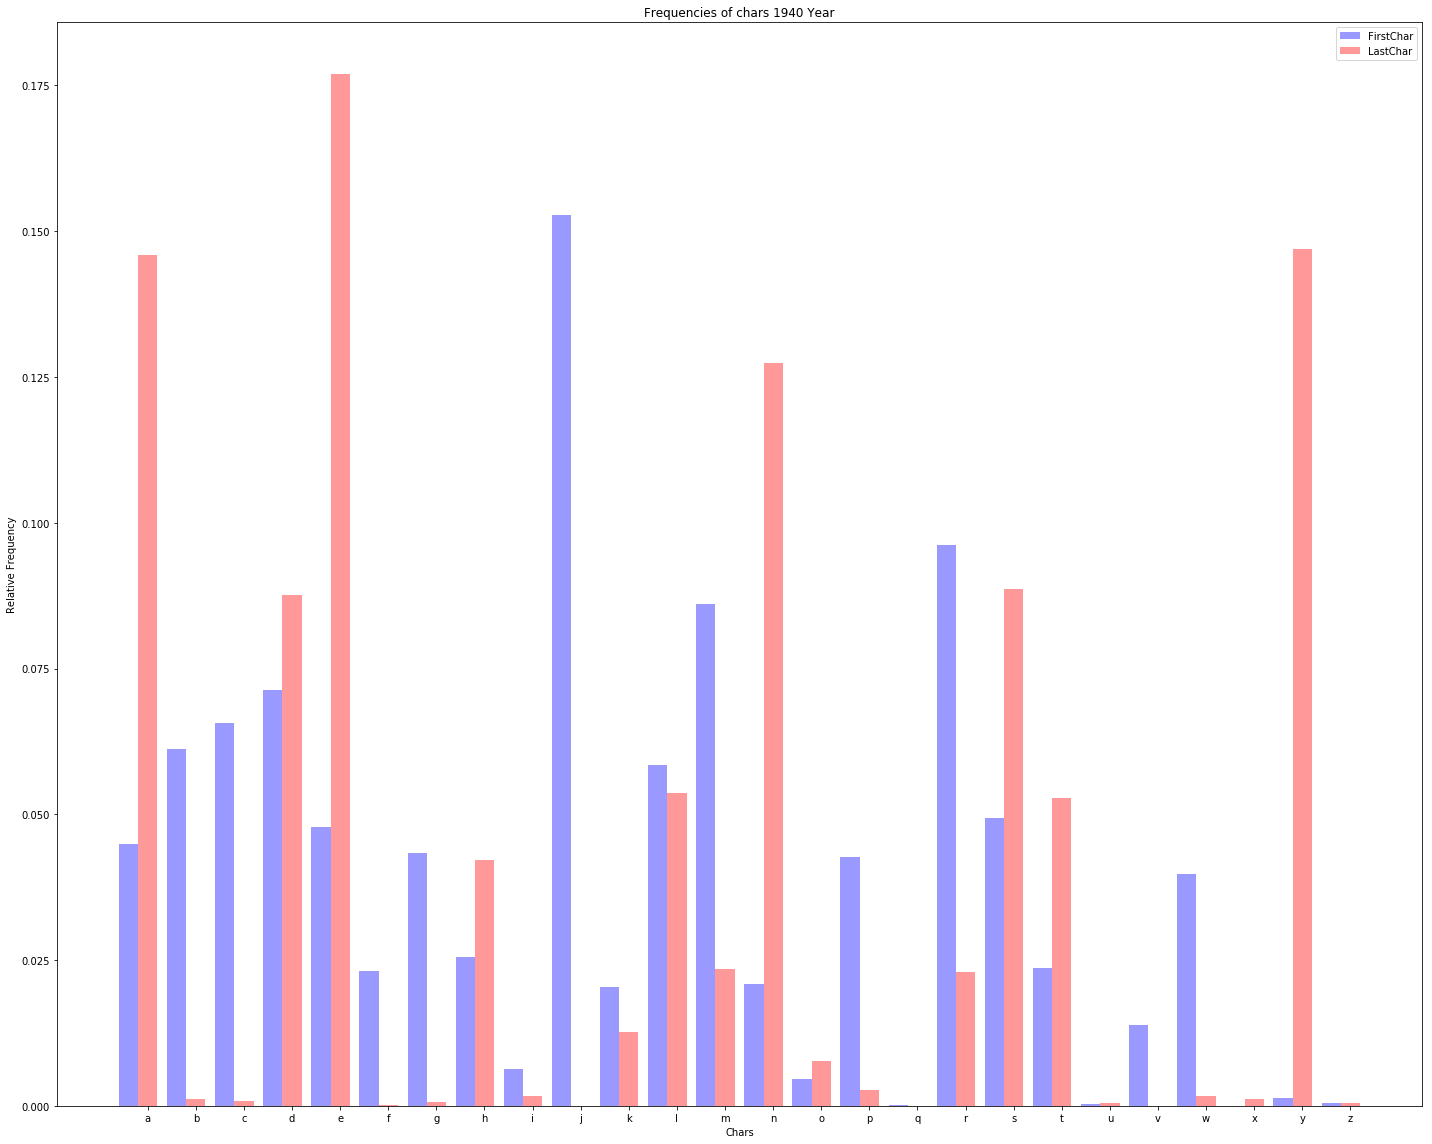

In [168]:
calculate_first_and_last_chars_statistics(read_data_frames[60])

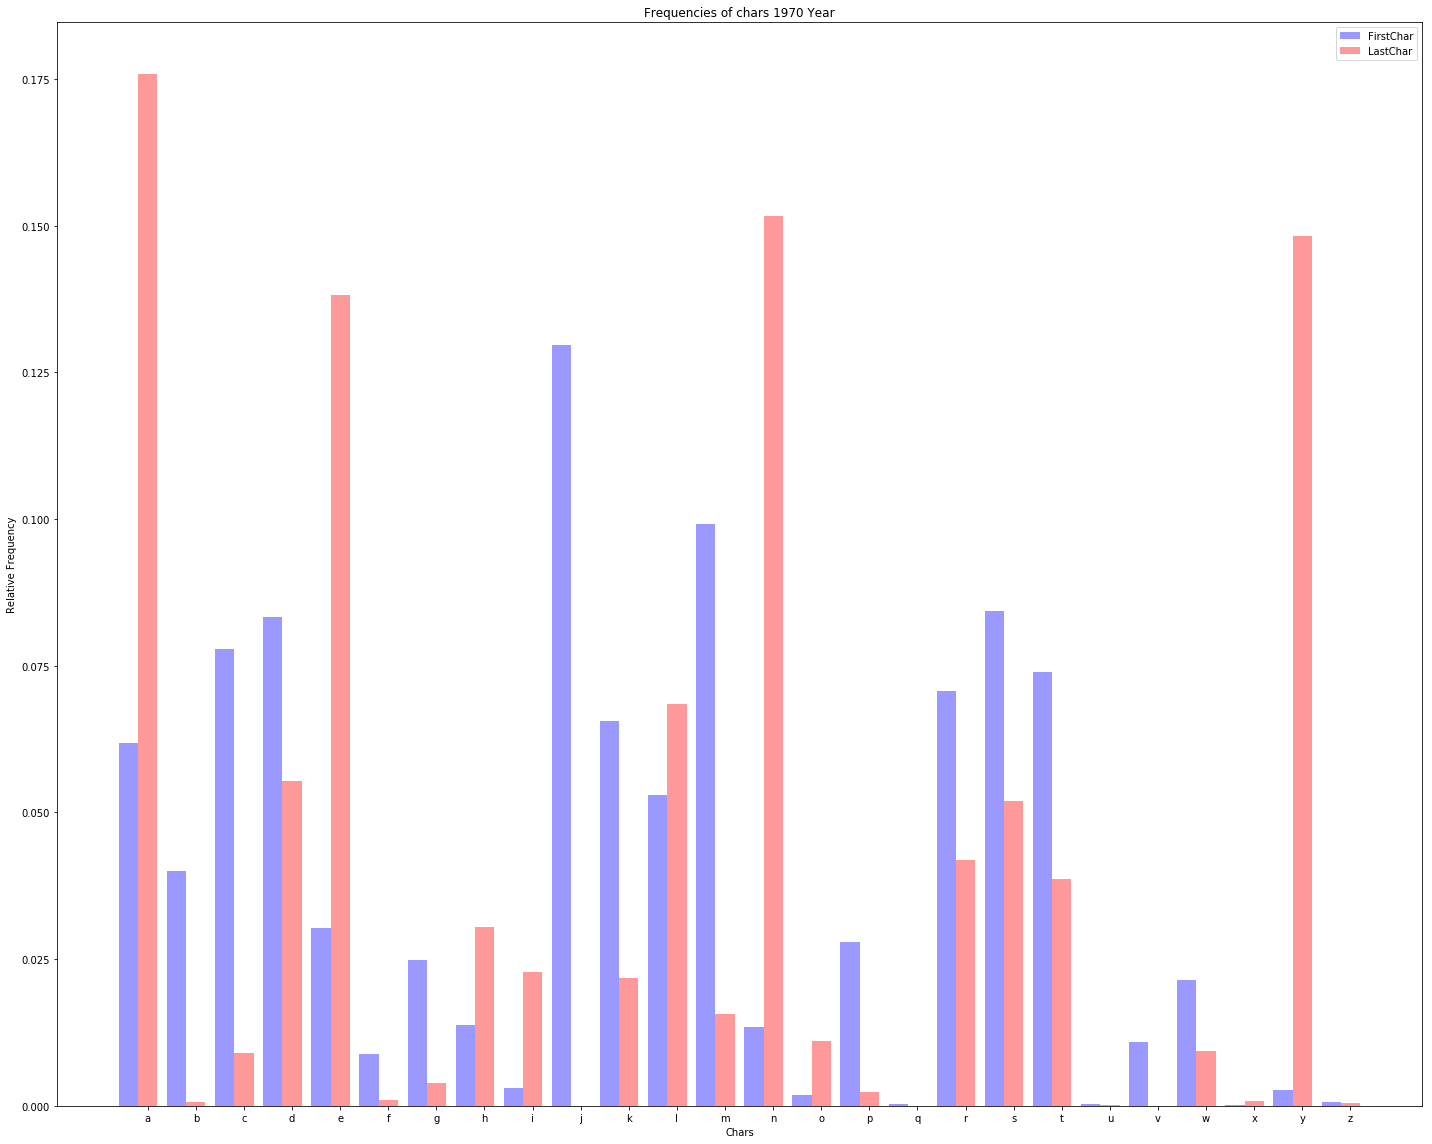

In [169]:
calculate_first_and_last_chars_statistics(read_data_frames[90])

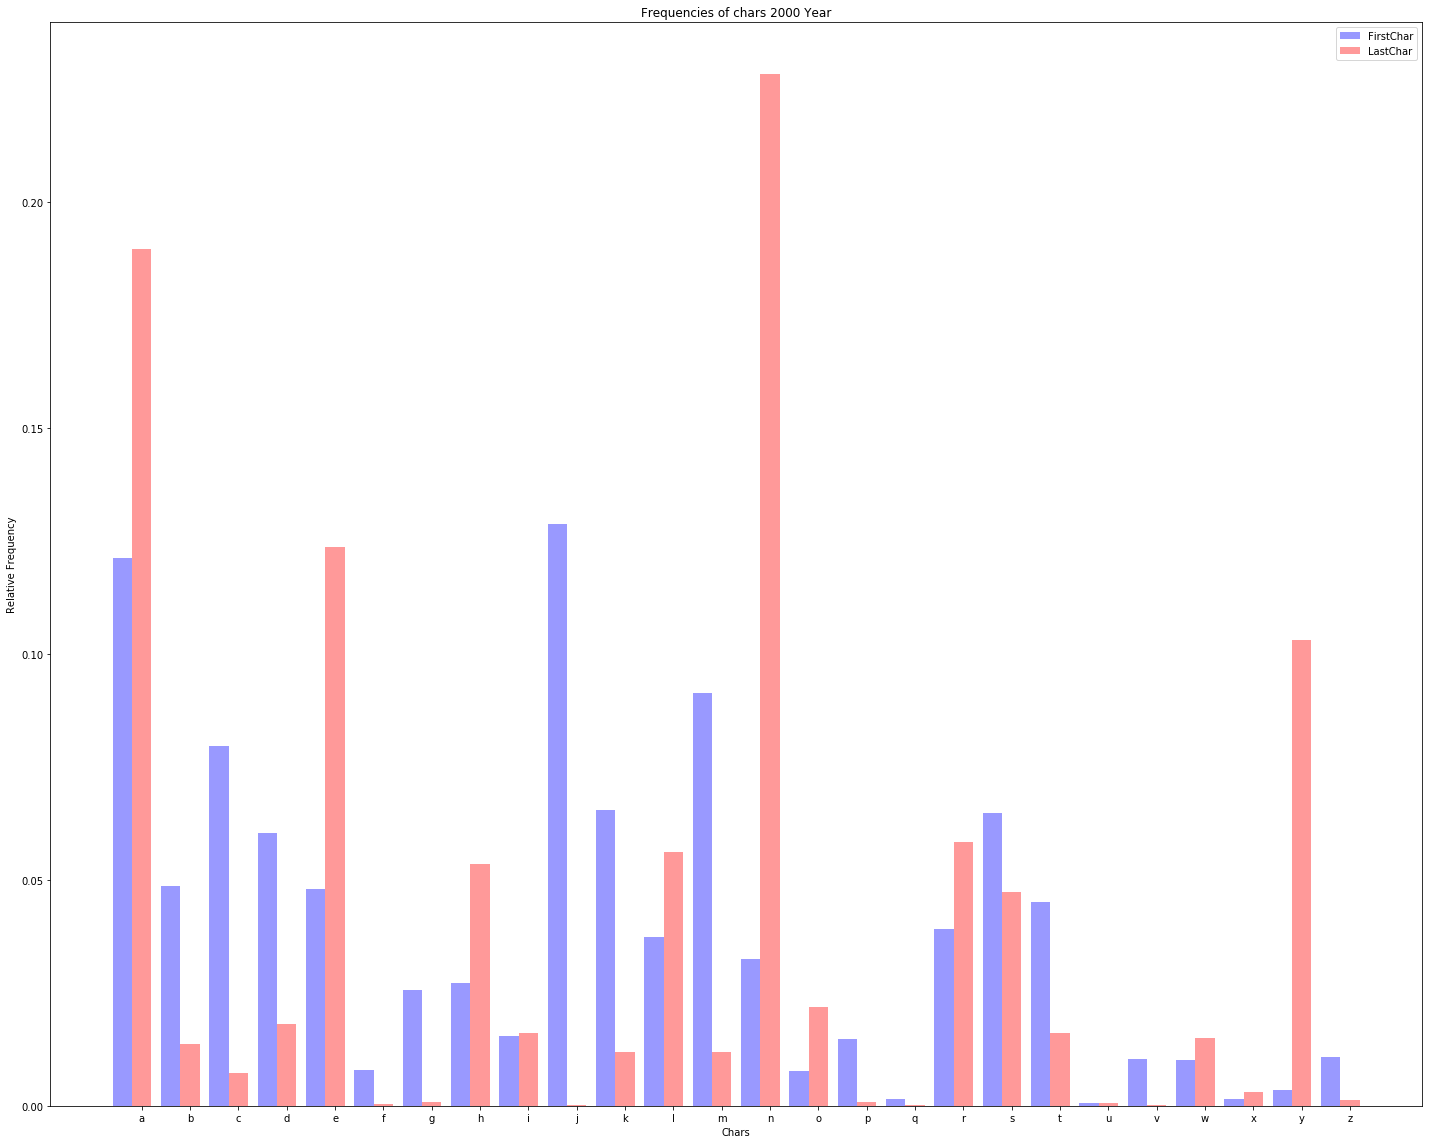

In [170]:
calculate_first_and_last_chars_statistics(read_data_frames[120])

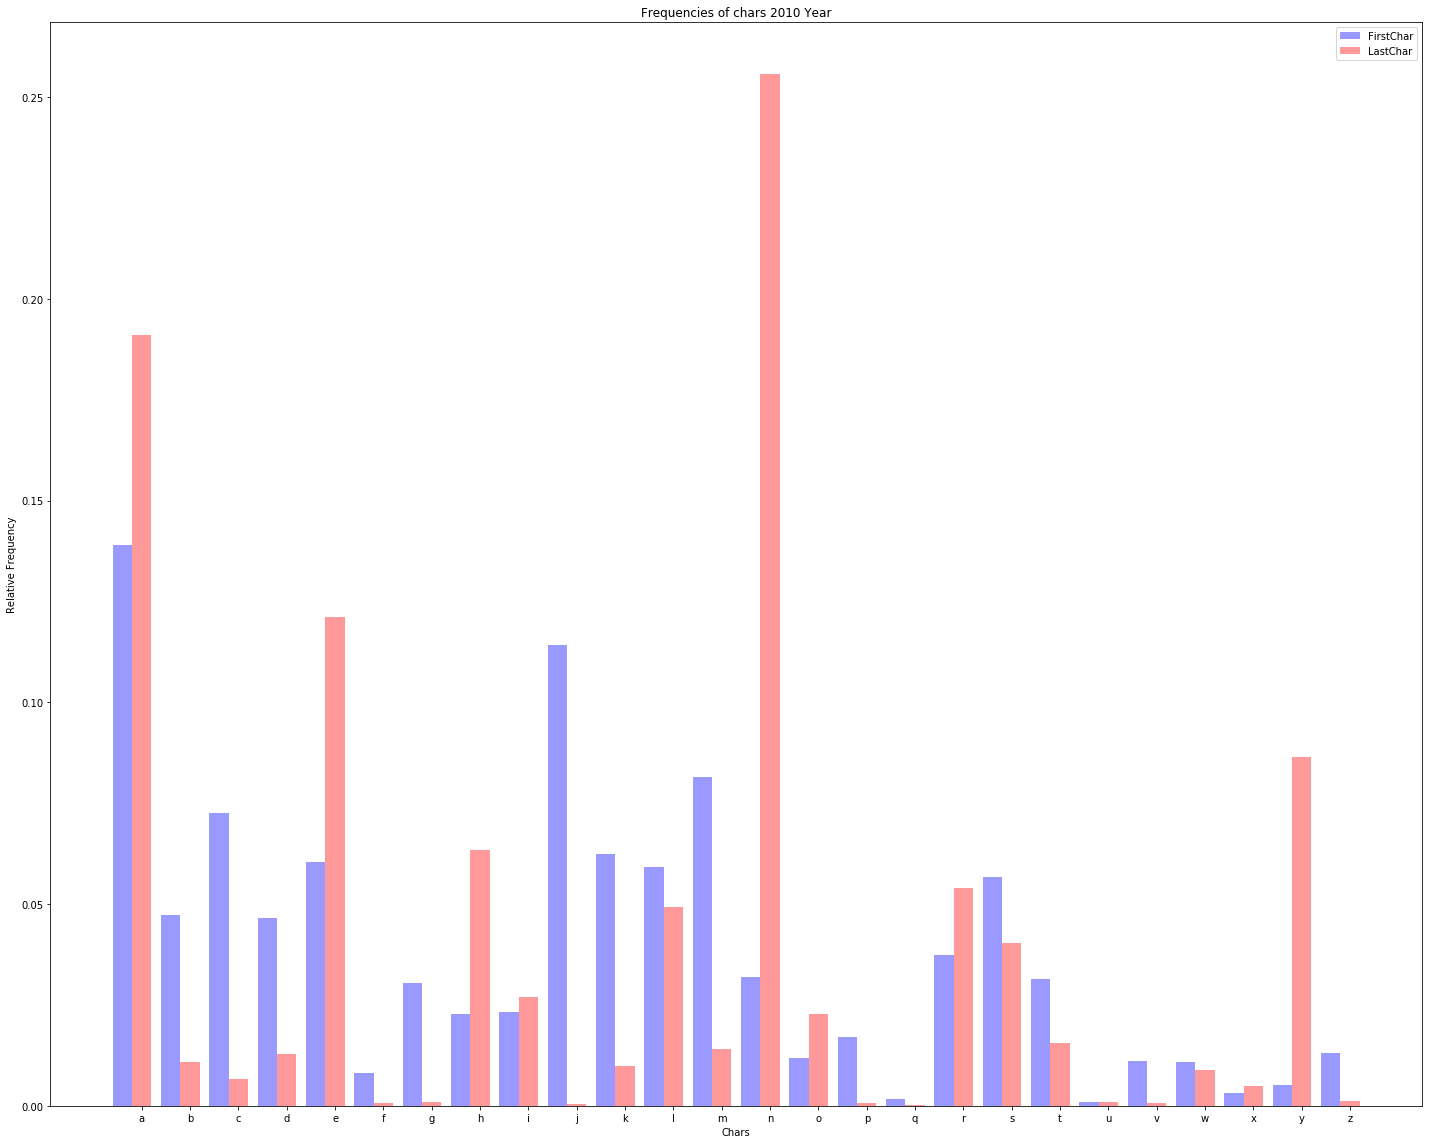

In [171]:
calculate_first_and_last_chars_statistics(read_data_frames[130])

# Выполнение пункта 6 задания "Составьте список из нескольких известных людей (президенты, певцы, актеры, киногерои) и оцените их влияние на динамику имен, постройте наглядную визуализацию"

Прошу прощения. Но я не знаю как выполнить этот пункт. В первом дата сете несколько сотен мужских и женскчих имён и лишь несколько десятков покрывают
 50 % населения. В последнем дата сете пара десятков тысяч мужских и женских имён. И порядка сотни покрывают 50% населения.    
Сказать что в какой - то момент имя Брюс стабо более популярно из-за известного человека, допустим Брюса Ли или Брюса Уилиса я считаю не корректным.
Я надеюсь что именно такой ответ является правильным для данного задания ^_^